In [30]:
import pandas as pd
from lightning import pytorch as pl
from pathlib import Path

from chemprop import data, featurizers, models, nn
from chemprop.nn import metrics
from chemprop.models import multi


In [31]:
info_reaction = pd.read_csv('/home/calvin/code/arc_analysis/reaction_data_info.csv')
reaction_data = pd.read_csv('/home/calvin/code/arc_analysis/reaction_data.csv')
# Merge the two dataframes on 'rxn'
merged_reaction_data = pd.merge(reaction_data, info_reaction, on='reaction')
conv_reaction_data = merged_reaction_data[merged_reaction_data['converged'] == True]


In [32]:
smiles_columns = ['reactant1', 'reactant2']
smiss = conv_reaction_data[smiles_columns].values
print(smiss)

[['C#C[C]=C' 'C#CCC#C']
 ['C[C](S)C' 'C=CC']
 ['C=CC' 'C[CH]c1ccccc1']
 ...
 ['[NH]CC#N' 'CO']
 ['[NH]CC#N' 'CC#N']
 ['[O]' 'CCSCC']]


In [33]:
# Fake y data - 100 for the number of reactions
ys = [1 for _ in range(len(smiss))]

In [34]:
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y) for smis, y in zip(smiss, ys)]]
all_data += [[data.MoleculeDatapoint.from_smi(smis[i]) for smis in smiss] for i in range(1, len(smiles_columns))]


[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not removing hydrogen atom without neighbors
[16:36:57] WARNING: not r

In [36]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()


In [67]:
all_datasets = [data.MoleculeDataset(all_data[i], featurizer) for i in range(2)]


In [73]:
all_datasets[0][0].mg.V

array([[0.     , 0.     , 0.     , 0.     , 0.     , 1.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 1.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        1.     , 0.     , 1.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 1.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.12011],
       [0.     , 0.     , 0.     , 0.     , 0.     , 1.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.    

In [87]:
import numpy as np
V_combined = np.vstack([all_datasets[0][0].mg.V, all_datasets[1][0].mg.V])
E_combined = np.vstack([all_datasets[0][0].mg.E, all_datasets[1][0].mg.E])

In [94]:
combined_data = []
for i in range(len(all_datasets[0])):
    V_combined = np.vstack([all_datasets[0][i].mg.V, all_datasets[1][i].mg.V])
    E_combined = np.vstack([all_datasets[0][i].mg.E, all_datasets[1][i].mg.E])
    # offset = all_datasets[0][i].mg.V.shape[0]
    # edge_index_combined = np.hstack([
    #     all_datasets[0][i].mg.edge_index,
    #     all_datasets[1][i].mg.edge_index + offset
    # ])
    # global_features_combined = np.hstack([
    #     all_datasets[0][i].mg.global_features,
    #     all_datasets[1][i].mg.global_features
    # ])
    combined_data.append({
        'V': V_combined,
        'E': E_combined,
        # 'edge_index': edge_index_combined,
    })

In [96]:
flattened_representation = [
    np.hstack([
        data['V'].flatten(),
        data['E'].flatten(),
        # data['edge_index'].flatten(),
    ]) for data in combined_data
]

In [98]:
len(flattened_representation)

1506

In [101]:
for i, rep in enumerate(flattened_representation):
    print(f"Representation {i} has length: {len(rep)}")


Representation 0 has length: 844
Representation 1 has length: 644
Representation 2 has length: 1072
Representation 3 has length: 1172
Representation 4 has length: 1272
Representation 5 has length: 344
Representation 6 has length: 972
Representation 7 has length: 744
Representation 8 has length: 1300
Representation 9 has length: 744
Representation 10 has length: 644
Representation 11 has length: 144
Representation 12 has length: 644
Representation 13 has length: 244
Representation 14 has length: 972
Representation 15 has length: 344
Representation 16 has length: 244
Representation 17 has length: 844
Representation 18 has length: 672
Representation 19 has length: 844
Representation 20 has length: 444
Representation 21 has length: 444
Representation 22 has length: 444
Representation 23 has length: 644
Representation 24 has length: 344
Representation 25 has length: 1072
Representation 26 has length: 444
Representation 27 has length: 744
Representation 28 has length: 744
Representation 29 h

In [102]:
max_length = max(len(rep) for rep in flattened_representation)

padded_representations = [
    np.pad(rep, (0, max_length - len(rep)), mode='constant') for rep in flattened_representation
]


In [104]:
for i, rep in enumerate(padded_representations):
    print(f"Representation {i} has length: {len(rep)}")


Representation 0 has length: 1828
Representation 1 has length: 1828
Representation 2 has length: 1828
Representation 3 has length: 1828
Representation 4 has length: 1828
Representation 5 has length: 1828
Representation 6 has length: 1828
Representation 7 has length: 1828
Representation 8 has length: 1828
Representation 9 has length: 1828
Representation 10 has length: 1828
Representation 11 has length: 1828
Representation 12 has length: 1828
Representation 13 has length: 1828
Representation 14 has length: 1828
Representation 15 has length: 1828
Representation 16 has length: 1828
Representation 17 has length: 1828
Representation 18 has length: 1828
Representation 19 has length: 1828
Representation 20 has length: 1828
Representation 21 has length: 1828
Representation 22 has length: 1828
Representation 23 has length: 1828
Representation 24 has length: 1828
Representation 25 has length: 1828
Representation 26 has length: 1828
Representation 27 has length: 1828
Representation 28 has length: 

In [99]:
from sklearn.decomposition import PCA

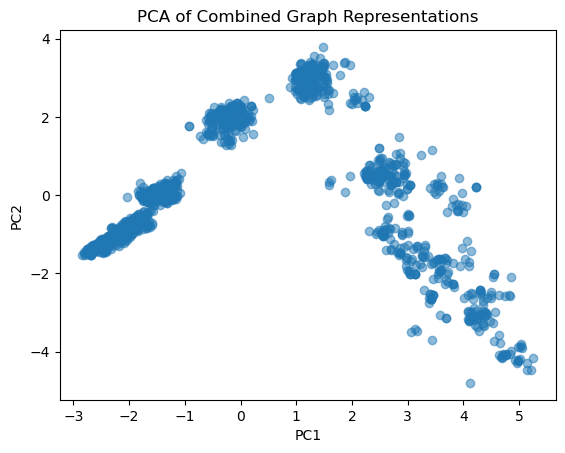

In [143]:
import matplotlib.pyplot as plt

# Convert list to array for PCA
data = np.array(padded_representations)

# Apply PCA
pca = PCA(n_components=40)
reduced_data = pca.fit_transform(data)

# Plot the PCA results
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Combined Graph Representations")
plt.show()

In [144]:
# Find the cumsum of explained variance
explained_variance = pca.explained_variance_ratio_
cumsum_explained_variance = np.cumsum(explained_variance)
print(cumsum_explained_variance)

[0.10870497 0.171089   0.22696649 0.28215777 0.32939689 0.37380803
 0.41033772 0.44520865 0.47406311 0.50243501 0.52773546 0.54857736
 0.56687843 0.58374329 0.59976336 0.6137839  0.62726432 0.63948247
 0.65121706 0.66240331 0.6730059  0.68296795 0.69246043 0.70123813
 0.7096762  0.71790189 0.72587253 0.73367398 0.74116314 0.74836406
 0.75525654 0.76169944 0.76803659 0.77404063 0.77974306 0.78539902
 0.79063404 0.79572974 0.80072884 0.80531239]


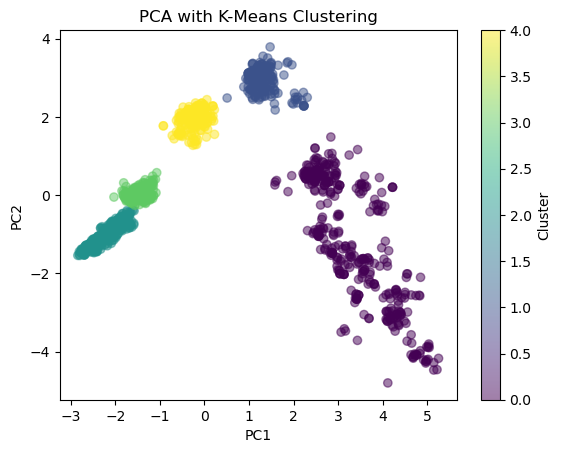

In [145]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(reduced_data)

# Visualize clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with K-Means Clustering")
plt.colorbar(label="Cluster")
plt.show()


In [146]:
print("PCA Component Loadings:")
print(pca.components_)
# Print the top contributing features for each principal component
top_features_pc1 = np.argsort(-np.abs(pca.components_[0]))[:10]
top_features_pc2 = np.argsort(-np.abs(pca.components_[1]))[:10]

print("Top contributing features for PC1:", top_features_pc1)
print("Top contributing features for PC2:", top_features_pc2)



PCA Component Loadings:
[[-1.22628992e-02  5.07004225e-19 -2.44560539e-19 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-8.02007048e-03  2.81193202e-17  1.12139830e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.91374078e-04 -6.30362383e-17 -3.37280101e-16 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 ...
 [-1.28888058e-02 -2.49624307e-17  1.57134964e-15 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 6.29208305e-02 -7.82581548e-16 -1.25859979e-15 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-1.03918427e-02  3.75048106e-16  8.18199507e-16 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]
Top contributing features for PC1: [627 697 625 555 769 699 483 553 725 653]
Top contributing features for PC2: [781 767 753 739 837 823 683 669 795 711]


In [147]:
import numpy as np
n_clusters = 3
representatives = []
for cluster in range(n_clusters):
    cluster_points = np.where(cluster_labels == cluster)[0]
    centroid = kmeans.cluster_centers_[cluster]
    closest_point = cluster_points[np.argmin(np.linalg.norm(reduced_data[cluster_points] - centroid, axis=1))]
    representatives.append(closest_point)

print("Representative points:", representatives)


Representative points: [996, 931, 430]


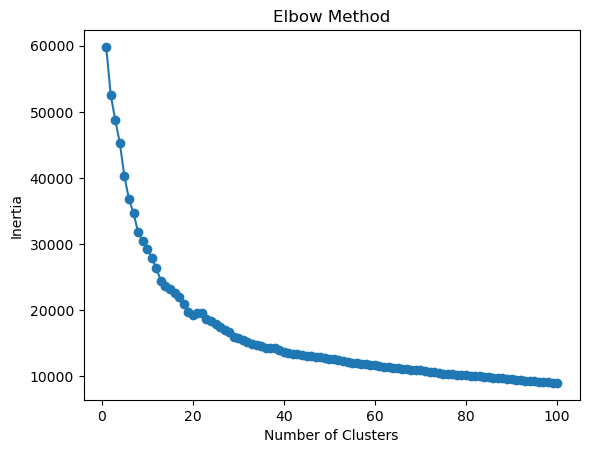

In [148]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use the reduced PCA data
inertia = []
for k in range(1, 101):  # Test for 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plot the inertia to find the "elbow"
plt.plot(range(1, 101), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()
# Print the best number of clusters based on the elbow method


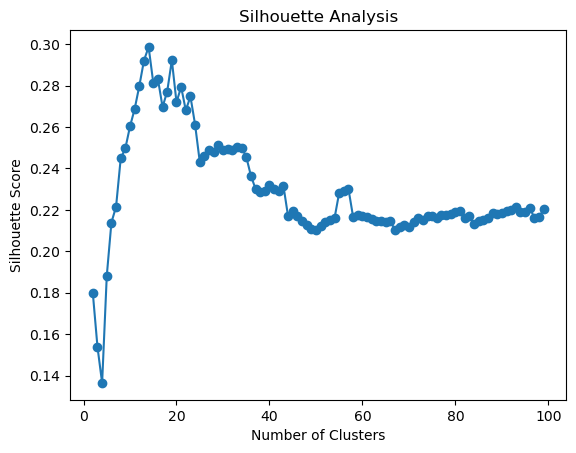

Best silhouette score: 0.2986759315626588 with 14 clusters


In [149]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 100):  # Test for 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    score = silhouette_score(reduced_data, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 100), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
# Put data table underneath
plt.show()
#Print the highest silhouette score and its corresponding number of clusters
best_score = max(silhouette_scores)
best_k = silhouette_scores.index(best_score) + 2
print(f"Best silhouette score: {best_score} with {best_k} clusters")

In [128]:
from sklearn.cluster import KMeans

# Use the determined number of clusters
n_clusters = 5  # Replace this with the optimal number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_


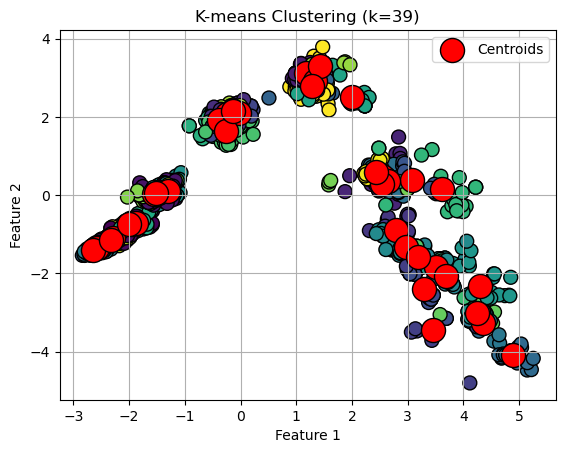

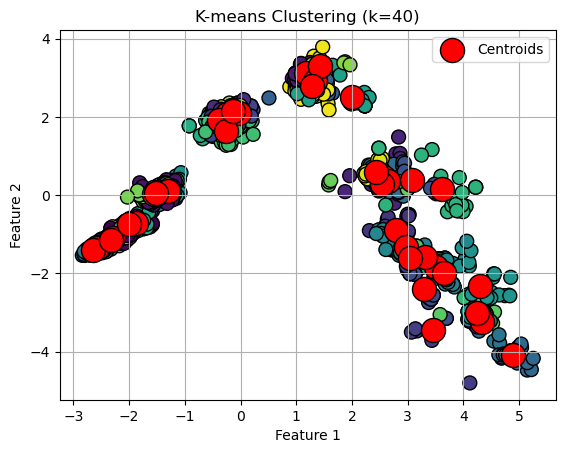

In [150]:
# Initialize a range of k values
k_range = range(39, 41)

# Fit and plot data for each k value
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(reduced_data)
    
    # Plot the clustered data points
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, cmap='viridis', marker='o', edgecolor='k', s=100)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=300, c='red', label='Centroids', edgecolor='k')
    plt.title(f'K-means Clustering (k={k})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid()
    plt.show()

In [132]:
import numpy as np

labeled_indices = []  # Store the indices of labeled points
unlabeled_indices = list(range(len(reduced_data)))  # All data points initially unlabeled
n_clusters = 5
# Start by labeling the centroids
for cluster in range(n_clusters):
    cluster_points = np.where(cluster_labels == cluster)[0]
    centroid = kmeans.cluster_centers_[cluster]
    closest_point = cluster_points[np.argmin(np.linalg.norm(reduced_data[cluster_points] - centroid, axis=1))]
    labeled_indices.append(closest_point)
    unlabeled_indices.remove(closest_point)

# Iterative labeling
while len(unlabeled_indices) > 0:
    # Compute distances to the labeled set
    distances = np.min(
        np.linalg.norm(reduced_data[unlabeled_indices] - reduced_data[labeled_indices][:, np.newaxis], axis=2),
        axis=0
    )

    # Select the farthest point
    next_point = unlabeled_indices[np.argmax(distances)]
    labeled_indices.append(next_point)
    unlabeled_indices.remove(next_point)

    # (Optionally) Break if you want to label a specific number of points
    # if len(labeled_indices) >= 10:  # Replace 10 with your desired number
    #     break


In [133]:
labeled_indices

[965,
 1102,
 175,
 573,
 69,
 878,
 1392,
 642,
 879,
 14,
 1489,
 1016,
 1487,
 1472,
 267,
 638,
 1084,
 369,
 1501,
 1202,
 1096,
 925,
 33,
 1066,
 43,
 990,
 780,
 1466,
 108,
 737,
 435,
 894,
 1354,
 253,
 501,
 1327,
 158,
 266,
 1043,
 1008,
 771,
 773,
 677,
 1137,
 257,
 357,
 781,
 890,
 1347,
 815,
 1001,
 1495,
 964,
 188,
 350,
 1484,
 1283,
 168,
 1214,
 8,
 976,
 1470,
 404,
 518,
 680,
 440,
 1410,
 1465,
 296,
 390,
 877,
 97,
 834,
 1277,
 71,
 233,
 136,
 1219,
 126,
 611,
 648,
 402,
 619,
 142,
 89,
 462,
 3,
 1419,
 192,
 44,
 418,
 1174,
 1172,
 746,
 1442,
 742,
 926,
 1504,
 1116,
 1134,
 1372,
 112,
 1186,
 379,
 1055,
 1119,
 144,
 800,
 217,
 29,
 871,
 239,
 479,
 453,
 1272,
 394,
 1093,
 940,
 812,
 565,
 700,
 234,
 245,
 153,
 1498,
 346,
 647,
 1266,
 958,
 328,
 63,
 252,
 330,
 981,
 1471,
 1039,
 1293,
 206,
 1211,
 1367,
 375,
 867,
 254,
 618,
 1359,
 1178,
 1407,
 1146,
 371,
 27,
 729,
 6,
 1035,
 170,
 1485,
 1443,
 526,
 124,
 54,
 576,
 43